# Google Trend Data

Ensure required packages are up to date in python distribution

In [ ]:
# import sys
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install pytrends
# !{sys.executable} -m pip install datetime
# !{sys.executable} -m pip install os

In [2]:
import pandas as pd
import os
from pytrends.request import TrendReq
from datetime import timedelta, date, datetime

### Enter start and end dates for time periods in question:
###### All dates in 'date(YYYY,MM,DD)' format

In [73]:
this_start_date = date(2020,10,11)      # Start date for this year's time period
this_end_date = date(2020,11,13)       # End date for this year's time period
last_start_date = date(2019,10,13)      # Start date for last year's time period
last_end_date = date(2019,11,15)       # End date for this year's time period

Calibration range (set's number of days to overlap date fields for calculating correlations)

In [74]:
overlap_days = 60                     # Default of 60 (days) works well

In [75]:
timeRange = (this_end_date - this_start_date).days + 1                                               #Formatting
overlapDay = this_start_date - timedelta((((this_start_date - last_end_date)/2).days))
corrStartDate = overlapDay - timedelta(overlap_days/2)
corrEndDate = overlapDay + timedelta(overlap_days/2)

#### Getting trend data for given time period

In [6]:
def getTrendData(keyword, start_date, end_date):
    
    """
    
    Parameters
    ----------
    keyword : STRING
        Keyword to get trend data for - works best in verbose format (i.e. - /m/05kv16)
    start_date : datetime.date
        Start date for trend data
    end_date : datetime.date
        End date for trend data

    Returns
    -------
    dataset : pandas.core.frame.DataFrame
        Output of trend data for given timeperiod.
        Daily data up to ~9 months time range
        Weekly data >9 months time range

    """
    
    pytrends = TrendReq(hl='en-US', tz=360)                      # Connecting to google servers 
    dataset = []

    timeFrame = (start_date.strftime('%Y-%m-%d')+ ' ' +          # Formatting start/end dates for trend payload
                end_date.strftime("%Y-%m-%d"))
    
    pytrends.build_payload(kw_list = [keyword],                 # Build trend payload for given keyword, timeframe, and geo-location
                        timeframe = timeFrame,
                        geo = 'US')
    
    data = pytrends.interest_over_time()                       # Generate trend data

    if not data.empty:                                         # Cleaning up data output
        data = data.drop(labels = ['isPartial'], 
                         axis ='columns')
        dataset.append(data)
            
    dataset = pd.concat(dataset, axis = 1)                     # Getting data into pandas dataframe for output
    
    return dataset

#### Calculating correction factor
A window is created where the two time ranges overlap with daily data (by _overlap_days_ number of days), and these timeframes are compared to calculate a correction factor to align each measurement as closely as possible. 
This ensures that last year's data and this year's data are using the same reference scale

In [7]:
def getCorrFactors(lastYearData, thisYearData):
    
    """

    Parameters
    ----------
    lastYearData : pandas.core.frame.DataFrame
        Output from getTrendData funtion for last year's timeframe
    thisYearData : pandas.core.frame.DataFrame
        Output from getTrendData function for this year's timeframe

    Returns
    -------
    result: float64
        Correction factor for last year's data

    """

    correctionFactors = []
    i = 0
    lastYearTail = pd.DataFrame(lastYearData.tail(overlap_days + 1))                    # Taking the end of last year's data
    thisYearHead = pd.DataFrame(thisYearData.head(overlap_days + 1))                    # Taking the start of this year's data
    for i in range(len(lastYearTail)):
        correctionFactors.append((lastYearTail.iloc[i][0]/thisYearHead.iloc[i][0]))     # For each day in the overlap window, calculate a correction factor 
        i += 1                                                                          # between the two seperate queries to align data

    return sum(correctionFactors)/len(correctionFactors)                                # Returns the average correction factor from above loop

#### Corrects data based on correction factor calculated above

In [8]:
def correctDailyData(data, correctionFactor):
    return data / correctionFactor

#### Calculating YOY change in Google Trend results

In [9]:
def calcYOY(keyword, this_start_date = this_start_date, this_end_date = this_end_date, 
            last_start_date = last_start_date, last_end_date= last_end_date,
            corrStartDate = corrStartDate, corrEndDate = corrEndDate):
    """

    Parameters
    ----------
    keyword : STRING
        Keyword to get trend data for - works best in verbose format (i.e. - /m/05kv16)
    this_start_date : datetime.date, optional
        Start date for this year's time frame. The default is this_start_date.
    this_end_date : datetime.date, optional
        End data for this year's time frame. The default is this_end_date.
    last_start_date : datetime.date, optional
        Start date for last year's time frame. The default is last_start_date.
    last_end_date : datetime.date, optional
        End data for last year's time frame. The default is last_end_date.
    corrStartDate : datetime.date, optional
        Calculated start of overlapping window for two queries. The default is corrStartDate.
    corrEndDate : datetime.date, optional
        Calculated end of overlapping window for two queries. The default is corrEndDate.

    Returns
    -------
    result: float, float, STRING
        Mean data for this year, last year, and a formatted string of YOY increase/decrease of keyword for given timeframe.

    """
    
    thisYearPlus = getTrendData(keyword, corrStartDate, this_end_date)         # Queries trend data for this year's time frame + overlap
    lastYearPlus = getTrendData(keyword, last_start_date, corrEndDate)         # Queries trend data for last year's time frame + overlap
    
    lastYearCorr = correctDailyData(lastYearPlus,                              # Corrects last year's (extended) data based on calculated correction factor
                                    getCorrFactors(lastYearPlus, 
                                                   thisYearPlus))                        
    
    thisYearAns = thisYearPlus.tail(timeRange).mean(axis=0)[0]                 # Calculates mean of this year's trend data for time frame provided
    lastYearAns = lastYearCorr.head(timeRange).mean(axis=0)[0]                 # Calculates mean of last year's trend data for time frame provided

    yoyIncrease = ((thisYearAns - lastYearAns)/ lastYearAns) * 100             # Calculating YOY increase 
    
    return thisYearAns, lastYearAns, str(round(yoyIncrease, 1)) + "%"         

#### Dictionary of search terms
Key: Reference  
Value: Keyword fed to getTrendData function - use getSuggestions to find verbose term where possible

In [62]:
kw_dict = {
    "Timberland": "/m/05kv16"
#     "Timberland Boots": "Timberland Boots",
#     "UGG": "/m/06wccjq",
#     "Dr Martens": "/m/01lsm6",
#     "Merrell": "/m/0kqrz3",
#     "The North Face": "/m/04n92b",
#     "Patagonia": "/m/0g152j",
#     "Allbirds": "/g/11g6j4k3hl"
#     "Vans": "/m/04kbwy",
#     "Amazon": "/m/0mgkg ",
#     "Walmart": "/m/0841v",
#     "Target": "/m/01b39j",
#     "Zappos": "/m/02dfb9",
#     "Foot Locker": "/m/08fhy9",
#     "Journeys": "/m/03cbgd",
#     "DSW": "/m/0flp70",
#     "Nordstrom": "/m/01fc_q",
#     "Macy's": "/m/01pkxd ",
#     "REI": "/m/02nx4d",
#     "Dick's Sports": "/m/06fgv_",
#     "Boot": "/m/01b638",
#     "Outerwear": "Outerwear",
#     "Sneakers":"/m/09kjlm",
#     "Boat Shoes":"/m/05q55b9",
#     "Sandals":"/m/03nfch",
#     "Hiking":"/m/012v4j",
#     "Sustainability":"/m/0hkst",
#     "Back to school":"Back to school",
#     "Jimmy Choo":"/m/0hkst",
#     "Timberland PRO":"Timberland PRO",
#     "Red Wing":"/m/0603n6",
#     "Carhartt":"/m/08vntw",
#     #"Wolverine":"/m/06ddr7",
#     "Dickies":"/m/03pjr5",
#     "Duluth":"/g/11f30mhkr2",
#     "Lowe's":"/m/037922",
#     "Home Depot":"/m/01zj1t",
#     "Grainger":"/m/0cp307",
#     # "Bobs":"Bobs",
#     "Boot Barn":"/g/11byc_x_1d",
#     "Work Boots":"Work Boots",
#     "Steel Toe Boots":"/m/01x101",
#     "Timberland Powertrain":"Timberland Powertrain",
#     "Safety Toe":"Safety Toe",
#     "Workwear":"/m/026lc7w",
#     "Nurse shoes":"Nurse shoes",
#     "Healthcare Discount":"Healthcare Discount",
#     "Responders Discount":"Responders Discount",
#     "Trade School":"/m/030x63",
#     "Home Improvement":"/m/03n2_q",
#     "DIY":"/m/017rcq"
    }

#### Calculating YOY results for the given keywords

In [11]:
lst_keywords = []

print("Adding keywords...")
for topic in kw_dict:                                        # Creating list of keywords
    lst_keywords.append(topic)

lst_values = []
ly_value = []
ty_value = []

print("Calculating...")
for topic in kw_dict:                                        # Calculating YOY results for each keyword in list
    print(topic)
    ty_value.append(round(calcYOY(kw_dict[topic])[0],1))
    ly_value.append(round(calcYOY(kw_dict[topic])[1],1))
    lst_values.append(calcYOY(kw_dict[topic])[2])

print("Combining...")
res = zip(lst_keywords, lst_values, ty_value, ly_value)     # Combining results into dataframe     
res = pd.DataFrame(res, 
                   columns = ['Keyword', 'YOY Change', 
                              'This Year', 'Last Year'])
res_horz = res.transpose()                                  # Horizontal representation

Adding keywords...
Calculating...
Timberland
Timberland Boots
UGG
Dr Martens
Combining...


#### Use this to get verbose suggestions for a given keyword

In [12]:
def getSuggestions(keyword):
    
    """
    Parameters:
    keyword: STRING 
        Keyword to look for suggestions for
    
    Returns:
    result: pandas.core.frame.DataFrame 
        Dateframe of suggestions, where mid is keyword ID for associated type
    """
    
    pytrends = TrendReq(hl='en-US', tz=360)                # Connect to Google servers
    
    suggestions = (pytrends.suggestions(keyword))          # Get suggestions on given keyword
    suggestions = pd.DataFrame(suggestions)                # Format as pandas dataframe
    
    return suggestions

### Results

In [13]:
print(res)

            Keyword YOY Change  This Year  Last Year
0        Timberland       1.0%       66.4       65.8
1  Timberland Boots       8.0%       73.2       67.8
2               UGG       9.3%       77.8       71.1
3        Dr Martens      29.9%       76.3       58.7


#### Output to csv in current working directory

In [14]:
filename = ('trends_output' + str(datetime.now().strftime("%Y%m%d-%H%M")) + '.csv')
res_horz.to_csv(filename)
print("File output to: {}".format(os.getcwd()))

File output to: C:\Users\zswitaj


#### To get suggestions for keywords

In [15]:
getSuggestions("Timberland")

,mid,title,type
0,/m/03f5spx,Timbaland,American musician
1,/m/05kv16,The Timberland Company,Footwear manufacturing company
2,/m/0j1yf,Justin Timberlake,American singer-songwriter
3,/m/02nm4q8,Timberland Regional Library,Public library system
4,/g/1tfbxw63,Timberland,Topic


##### Export notebook to share

In [16]:
!jupyter nbconvert --to script TrendsDataYOY.ipynb;

This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.


[NbConvertApp] WARNING | pattern 'TrendsDataYOY.ipynb;' matched no files


To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
    Equivalent to: [--ExecutePreprocessor.allow_errors=True]
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
    Equivalent to: [--NbConvertApp.from_stdin=True]
--std

In [33]:
import matplotlib.pyplot as plt

In [34]:
tbl = calcYOY("/m/05kv16")

In [55]:
tbl_this = 
tbl_last = getTrendData("/m/05kv16",date(2019,10,13), date(2019,11,15))

In [56]:
import seaborn as sns

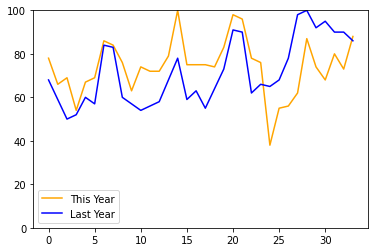

In [59]:
plt.ylim(0,100)
plt.plot(range(len(tbl_this)), tbl_this, color= 'orange', label = 'This Year')
plt.plot(range(len(tbl_this)), tbl_last, color='blue', label = 'Last Year')
plt.legend()

In [61]:
calcYOY("/m/05kv16")

(67.46428571428571, 65.46091708985963, '3.1%')

In [83]:
def calcYOY2(keyword, this_start_date = this_start_date, this_end_date = this_end_date, 
            last_start_date = last_start_date, last_end_date= last_end_date,
            corrStartDate = corrStartDate, corrEndDate = corrEndDate):
    
    thisYearPlus = getTrendData(keyword, corrStartDate, this_end_date)         # Queries trend data for this year's time frame + overlap
    lastYearPlus = getTrendData(keyword, last_start_date, corrEndDate)         # Queries trend data for last year's time frame + overlap
    
    lastYearCorr = correctDailyData(lastYearPlus,                              # Corrects last year's (extended) data based on calculated correction factor
                                    getCorrFactors(lastYearPlus, 
                                                   thisYearPlus))                        
    
    thisYearAns = thisYearPlus.tail(timeRange).mean(axis=0)[0]                 # Calculates mean of this year's trend data for time frame provided
    lastYearAns = lastYearCorr.head(timeRange).mean(axis=0)[0]                 # Calculates mean of last year's trend data for time frame provided

    yoyIncrease = ((thisYearAns - lastYearAns)/ lastYearAns) * 100             # Calculating YOY increase 
    
    return thisYearPlus.tail(timeRange), lastYearCorr.head(timeRange), thisYearAns, lastYearAns   

In [84]:
tbl_this, tbl_last, this, last = calcYOY2("/m/05kv16")

In [117]:
x_range = pd.date_range(start = this_start_date, end = this_end_date)

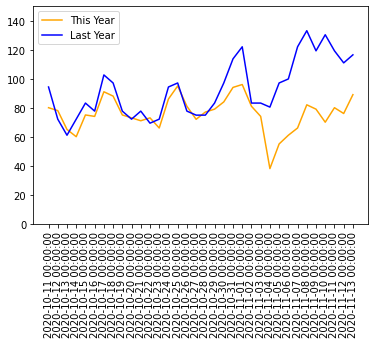

In [115]:
fig, ax = plt.subplots()
plt.ylim(0,150)
plt.xticks(ticks = range(len(tbl_this)), labels = x_range)
plt.xticks(rotation = 90)
plt.plot(range(len(tbl_this)), tbl_this, color= 'orange', label = 'This Year')
plt.plot(range(len(tbl_this)), tbl_last, color='blue', label = 'Last Year')
plt.legend()

In [97]:
pd.date_range(start = this_start_date, end = this_end_date)

DatetimeIndex(['2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18',
               '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
               '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26',
               '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
               '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03',
               '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07',
               '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13'],
              dtype='datetime64[ns]', freq='D')